In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!git clone https://github.com/jimsonjames0/CS-576-Final-Project.git
%cd CS-576-Final-Project
!git checkout mudit

Mounted at /content/drive
Cloning into 'CS-576-Final-Project'...
remote: Enumerating objects: 64416, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 64416 (delta 16), reused 10 (delta 2), pack-reused 64373 (from 2)
Receiving objects: 100% (64416/64416), 1.36 GiB | 16.22 MiB/s, done.
Resolving deltas: 100% (160/160), done.
/content/CS-576-Final-Project
Branch 'mudit' set up to track remote branch 'mudit' from 'origin'.
Switched to a new branch 'mudit'


In [5]:
!nvidia-smi

Mon Oct 13 06:15:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install torch torchvision torchaudio snntorch matplotlib tqdm numpy soundfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 11.1 MB/s eta 0:00:00


In [3]:
!mkdir -p snn_conversion
!touch snn_conversion/SNN_Conversion.ipynb

In [11]:
import os

MODEL_PATH = "/content/CS-576-Final-Project/saved_models/baseline_cnn_kws_vfinal.pt"
DATA_DIR = DATA_DIR = "/content/drive/MyDrive/SpeechCommands"

print("✅ Model found:", os.path.exists(MODEL_PATH))
print("✅ Dataset found:", os.path.exists(DATA_DIR))

✅ Model found: True
✅ Dataset found: True


In [8]:
import torch
import torch.nn as nn

# Define same CNN structure as training
class CNN_KWS(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Use LazyLinear to automatically infer correct input size
        self.classifier = nn.Sequential(
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Load trained weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_KWS().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

print("✅ CNN model loaded successfully on", device)

✅ CNN model loaded successfully on cuda


In [22]:
# # Phase 2 — ANN ➜ SNN (snntorch)
# T4 GPU friendly, no extra training required (rate-coded inference).

# %%
!pip -q install snntorch==0.9.4

import os, torch, torchaudio, numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
import torchaudio.transforms as T

import snntorch as snn
from snntorch import functional as SF
from snntorch import surrogate

print("PyTorch:", torch.__version__)
print("Torchaudio:", torchaudio.__version__)
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

PyTorch: 2.8.0+cu126
Torchaudio: 2.8.0+cu126
CUDA available: True


device(type='cuda')

In [44]:
# Correct dataset path for torchaudio
import os

# Base location where you uploaded the dataset
BASE_DIR = "/content/drive/MyDrive/SpeechCommands"

# Automatically locate the real "speech_commands_v0.02" folder inside Drive
DATA_DIR = "/content/drive/MyDrive"
print("✅ Using DATA_DIR =", DATA_DIR)

from torchaudio.datasets import SPEECHCOMMANDS

# Small keyword set
CLASSES = ["yes","no","go","stop","down","up"]

SAMPLE_RATE = 16000
N_MFCC = 40
mfcc_transform = T.MFCC(
    sample_rate=SAMPLE_RATE,
    n_mfcc=N_MFCC,
    melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 40, "center": False}
)

class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset, classes):
        super().__init__(root=DATA_DIR, download=False)
        self.subset = subset
        self.classes = classes
        self._walker = self._load_list(subset)

    def _load_list(self, subset):
        base = os.path.join(self._path)
        val_list  = os.path.join(base, "validation_list.txt")
        test_list = os.path.join(base, "testing_list.txt")

        def read_list(path):
            with open(path, "r") as f:
                return set(line.strip() for line in f)

        val_files  = read_list(val_list)
        test_files = read_list(test_list)

        if subset == "validation":
            return [os.path.join(base, f) for f in val_files if f.split("/")[0] in self.classes]
        elif subset == "testing":
            return [os.path.join(base, f) for f in test_files if f.split("/")[0] in self.classes]
        else:
            all_files = []
            for label in self.classes:
                folder = os.path.join(base, label)
                if os.path.isdir(folder):
                    for file in os.listdir(folder):
                        path = os.path.join(label, file)
                        if path not in val_files and path not in test_files:
                            all_files.append(os.path.join(base, path))
            return all_files

    def __getitem__(self, n):
      path = self._walker[n]
      try:
          waveform, sr = torchaudio.load(path)
      except Exception as e:
          # If file missing or unreadable, skip and get next
          print(f"⚠️ Skipping missing file: {path}")
          return self.__getitem__((n + 1) % len(self._walker))

      label = path.split("/")[-2]
      label_idx = self.classes.index(label)
      mfcc = mfcc_transform(waveform).squeeze(0)
      x = (mfcc - mfcc.min()) / (mfcc.max() - mfcc.min() + 1e-6)
      return x, label_idx

# pad to common time length within a batch
import torch.nn.functional as F
def pad_sequence(batch):
    tensors, targets = zip(*batch)
    max_len = max(t.shape[1] for t in tensors)
    padded = [F.pad(t, (0, max_len - t.shape[1])) for t in tensors]
    padded = torch.stack(padded)              # [B, 40, T]
    targets = torch.tensor(targets)
    return padded, targets

# Dataloaders
BATCH_SIZE = 128
train_set = SubsetSC("training", CLASSES)
val_set   = SubsetSC("validation", CLASSES)
test_set  = SubsetSC("testing", CLASSES)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_sequence)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_sequence)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_sequence)

len(train_set), len(val_set), len(test_set)

✅ Using DATA_DIR = /content/drive/MyDrive


(18657, 2252, 2468)

In [51]:
import torch
import torch.nn as nn

# Define CNN with LazyLinear (matches saved model)
class CNN_KWS(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)       # [B, 1, 40, T]
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Initialize and load weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_KWS().to(device)

# ⚠️ Replace this dummy with real MFCC initialization
# use one MFCC sample from your training loader to initialize LazyLinear correctly
x_real, _ = next(iter(train_loader))
x_real = x_real[:2].to(device)  # take 2 samples
_ = model(x_real)               # triggers LazyLinear init with correct flatten size

# Now load trained weights from repo
MODEL_PATH = "/content/CS-576-Final-Project/saved_models/baseline_cnn_kws_vfinal.pt"

# --- 🔧 STEP 2: Normalize CNN activation rates before SNN conversion ---
# --- 🔧 STEP 2: Normalize CNN activation ranges manually ---
import torch

def normalize_cnn_activations(model, x_sample, percentile=99):
    """
    Mimics SF.rate_conv(): rescales Conv/Linear weights
    so neuron activations fall within a good dynamic range.
    """
    with torch.no_grad():
        x = x_sample.unsqueeze(1)  # [B, 1, 40, T]
        for layer in model.features:
            x = layer(x)
            if isinstance(layer, torch.nn.ReLU):
                p = torch.quantile(x.abs().flatten(), percentile / 100)
                scale = 1.0 / (p + 1e-6)
                x *= scale
        # Pass through classifier (to trigger shapes)
        x = torch.flatten(x, 1)
        for layer in model.classifier:
            x = layer(x)
            if isinstance(layer, torch.nn.ReLU):
                p = torch.quantile(x.abs().flatten(), percentile / 100)
                scale = 1.0 / (p + 1e-6)
                x *= scale
    print("✅ Manual activation normalization done.")

# Small real batch for calibration
x_real, _ = next(iter(train_loader))
x_real = x_real[:8].to(device)

normalize_cnn_activations(model, x_real, percentile=99)

# Just trigger a forward pass to confirm everything works
with torch.no_grad():
    _ = model(x_real)

print("✅ CNN activation normalization completed successfully.")

✅ Manual activation normalization done.
✅ CNN activation normalization completed successfully.


In [52]:
# ## Convert the trained CNN → SNN (using snntorch Leaky Integrate-and-Fire neurons)

import snntorch as snn
from snntorch import surrogate
import torch.nn.functional as F
import torch.nn as nn

# surrogate gradient for spike backprop (required even if not training)
spike_grad = surrogate.fast_sigmoid()

# Define an SNN wrapper using CNN weights
class SNN_KWS(nn.Module):
    def __init__(self, base_cnn, num_steps=50, beta=0.95):
        super().__init__()
        self.num_steps = num_steps
        self.features = base_cnn.features
        self.fc1 = base_cnn.classifier[0]  # Linear(?, 64)
        self.fc2 = base_cnn.classifier[2]  # Linear(64, num_classes)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):
        """
        x: [B, 40, T] MFCC input
        returns: [T, B, num_classes] spike tensor
        """
        spk2_rec = []
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # reshape for CNN [B, 1, 40, T]
        x = x.unsqueeze(1)

        for step in range(self.num_steps):
            cur = self.features(x)
            cur = torch.flatten(cur, 1)
            cur = F.relu(self.fc1(cur))
            spk1, mem1 = self.lif1(cur, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)

        return torch.stack(spk2_rec)  # [T, B, num_classes]


# --- Instantiate & copy CNN weights ---
snn_model = SNN_KWS(model, num_steps=50).to(device)

# Copy weights directly from CNN
with torch.no_grad():
    snn_model.features.load_state_dict(model.features.state_dict())
    snn_model.fc1.load_state_dict(model.classifier[0].state_dict())
    snn_model.fc2.load_state_dict(model.classifier[2].state_dict())

print("✅ SNN model created successfully with Leaky-Integrate-and-Fire neurons (T=50).")

✅ SNN model created successfully with Leaky-Integrate-and-Fire neurons (T=50).


In [56]:
# ### Inference with rate coding (no extra training)
import torch
import numpy as np
from tqdm import tqdm

@torch.no_grad()
def poisson_rate_code(x, T):
    """
    x: [B, 40, time] in [0,1]
    returns tensor [T, B, 40, time] of Bernoulli spikes
    """
    return torch.stack([torch.bernoulli(x) for _ in range(T)])  # [T, B, 40, time]

@torch.no_grad()
def eval_snn(loader, snn_model, T=50, device="cuda"):
    snn_model.eval()
    total, correct = 0, 0

    for mfcc, y in tqdm(loader, desc=f"Eval SNN @T={T}"):
        mfcc, y = mfcc.to(device), y.to(device)

        # the SNN already runs for num_steps=T internally
        out_TBC = snn_model(mfcc)           # [T, B, num_classes]
        logits = out_TBC.sum(dim=0)         # [B, num_classes]
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.numel()

    return correct / total


# --- Run Inference ---
T_STEPS = 50
val_acc  = eval_snn(val_loader,  snn_model, T=T_STEPS, device=device)
test_acc = eval_snn(test_loader, snn_model, T=T_STEPS, device=device)

print(f"\nSNN VAL  Acc @T={T_STEPS}: {val_acc*100:.2f}%")
print(f"SNN TEST Acc @T={T_STEPS}: {test_acc*100:.2f}%")

Eval SNN @T=50: 100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


SNN VAL  Acc @T=50: 17.63%
SNN TEST Acc @T=50: 16.98%


In [64]:
import torch
import numpy as np
from tqdm import tqdm

@torch.no_grad()
def eval_snn_energy(loader, snn_model, T=25, device="cuda"):
    snn_model.eval()
    total, correct = 0, 0
    total_spikes = 0
    num_neurons = 0

    for mfcc, y in tqdm(loader, desc=f"Eval SNN @T={T}"):
        mfcc, y = mfcc.to(device), y.to(device)
        out_TBC = snn_model(mfcc)        # [T, B, num_classes]
        spikes = (out_TBC > 0).float().sum().item()  # total spiking activity
        total_spikes += spikes
        num_neurons += out_TBC.numel()   # T × B × C

        logits = out_TBC.sum(dim=0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.numel()

    accuracy = correct / total
    avg_spike_rate = total_spikes / num_neurons
    energy_score = avg_spike_rate * T  # proportional energy proxy

    return accuracy, avg_spike_rate, energy_score

In [55]:
# Step 4: Fine-tune SNN with surrogate gradient training
optimizer = torch.optim.Adam(snn_model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(3):  # try 3-5 epochs
    snn_model.train()
    total_loss = 0
    for mfcc, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        mfcc, y = mfcc.to(device), y.to(device)
        optimizer.zero_grad()
        out_TBC = snn_model(mfcc)
        logits = out_TBC.sum(dim=0)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")

Epoch 1:   0%|          | 0/146 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audi

Epoch 1 | Loss: 3.0325


Epoch 2: 100%|██████████| 146/146 [02:27<00:00,  1.01s/it]


Epoch 2 | Loss: 1.8583


Epoch 3: 100%|██████████| 146/146 [02:28<00:00,  1.02s/it]

Epoch 3 | Loss: 1.7918


In [63]:
import torch
from tqdm import tqdm

@torch.no_grad()
def eval_cnn(loader, model, device="cuda"):
    model.eval()
    total, correct = 0, 0
    for mfcc, y in tqdm(loader, desc="Eval CNN"):
        mfcc, y = mfcc.to(device), y.to(device)
        out = model(mfcc)
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / total

cnn_val_acc  = eval_cnn(val_loader, model, device)
cnn_test_acc = eval_cnn(test_loader, model, device)

# Rough CNN energy proxy (multiply-accumulate count per inference)
cnn_energy_proxy = 1.0   # baseline = 1×
print(f"✅ CNN VAL  Acc: {cnn_val_acc*100:.2f}%")
print(f"✅ CNN TEST Acc: {cnn_test_acc*100:.2f}%")

Eval CNN: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]

✅ CNN VAL  Acc: 18.03%
✅ CNN TEST Acc: 16.41%


In [65]:
results = []
T_values = [10, 25, 50, 75, 100]
beta_values = [0.90, 0.95, 0.97, 0.99]

for beta in beta_values:
    # rebuild the SNN with a new leak constant
    snn_model = SNN_KWS(model, num_steps=50, beta=beta).to(device)
    print(f"\n===== β={beta} =====")
    for T in T_values:
        val_acc, spike_rate, energy = eval_snn_energy(val_loader, snn_model, T=T, device=device)
        test_acc, _, _ = eval_snn_energy(test_loader, snn_model, T=T, device=device)
        results.append({
            "beta": beta,
            "T": T,
            "val_acc": val_acc * 100,
            "test_acc": test_acc * 100,
            "avg_spike_rate": spike_rate,
            "energy_score": energy
        })

# Add CNN baseline
results.append({
    "model": "CNN",
    "beta": "-",
    "T": "-",
    "val_acc": cnn_val_acc * 100,
    "test_acc": cnn_test_acc * 100,
    "avg_spike_rate": 0,
    "energy_proxy": cnn_energy_proxy
})

df = pd.DataFrame(results)
display(df)


===== β=0.9 =====


Eval SNN @T=100: 100%|██████████| 20/20 [00:17<00:00,  1.14it/s]



===== β=0.95 =====


Eval SNN @T=100: 100%|██████████| 20/20 [00:17<00:00,  1.15it/s]



===== β=0.97 =====


Eval SNN @T=100: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s]



===== β=0.99 =====


Eval SNN @T=100: 100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


,beta,T,val_acc,test_acc,avg_spike_rate,energy_score,model,energy_proxy
0,0.9,10,17.628774,16.977310,0.000000,0.000000,NaN,NaN
1,0.9,25,17.628774,16.977310,0.000000,0.000000,NaN,NaN
2,0.9,50,17.628774,16.977310,0.000000,0.000000,NaN,NaN
3,0.9,75,17.628774,16.977310,0.000000,0.000000,NaN,NaN
4,0.9,100,17.628774,16.977310,0.000000,0.000000,NaN,NaN
5,0.95,10,17.628774,16.977310,0.000000,0.000000,NaN,NaN
6,0.95,25,17.628774,16.977310,0.000000,0.000000,NaN,NaN
7,0.95,50,17.628774,16.977310,0.000000,0.000000,NaN,NaN
8,0.95,75,17.628774,16.977310,0.000000,0.000000,NaN,NaN
9,0.95,100,17.628774,16.977310,0.000000,0.000000,NaN,NaN


In [66]:
df["relative_energy"] = df["energy_proxy"] / cnn_energy_proxy
df["efficiency"] = df["test_acc"] / df["relative_energy"]
display(df.sort_values(by=["model","beta","T"]))

,beta,T,val_acc,test_acc,avg_spike_rate,energy_score,model,energy_proxy,relative_energy,efficiency
20,-,-,18.028419,16.410049,0.000000,NaN,CNN,1.0,1.0,16.410049
0,0.9,10,17.628774,16.977310,0.000000,0.000000,NaN,NaN,NaN,NaN
1,0.9,25,17.628774,16.977310,0.000000,0.000000,NaN,NaN,NaN,NaN
2,0.9,50,17.628774,16.977310,0.000000,0.000000,NaN,NaN,NaN,NaN
3,0.9,75,17.628774,16.977310,0.000000,0.000000,NaN,NaN,NaN,NaN
4,0.9,100,17.628774,16.977310,0.000000,0.000000,NaN,NaN,NaN,NaN
5,0.95,10,17.628774,16.977310,0.000000,0.000000,NaN,NaN,NaN,NaN
6,0.95,25,17.628774,16.977310,0.000000,0.000000,NaN,NaN,NaN,NaN
7,0.95,50,17.628774,16.977310,0.000000,0.000000,NaN,NaN,NaN,NaN
8,0.95,75,17.628774,16.977310,0.000000,0.000000,NaN,NaN,NaN,NaN


In [70]:
# Compute relative energy and efficiency safely
if "efficiency" not in df.columns:
    cnn_energy_proxy = 1.0
    df["relative_energy"] = df["energy_proxy"] / cnn_energy_proxy
    df["efficiency"] = df["test_acc"] / df["relative_energy"]
display(df.head())


,beta,T,val_acc,test_acc,avg_spike_rate,energy_score,model,energy_proxy,relative_energy,efficiency
0,0.9,10,17.628774,16.97731,0.0,0.0,NaN,NaN,NaN,NaN
1,0.9,25,17.628774,16.97731,0.0,0.0,NaN,NaN,NaN,NaN
2,0.9,50,17.628774,16.97731,0.0,0.0,NaN,NaN,NaN,NaN
3,0.9,75,17.628774,16.97731,0.0,0.0,NaN,NaN,NaN,NaN
4,0.9,100,17.628774,16.97731,0.0,0.0,NaN,NaN,NaN,NaN


In [73]:
df["model"].fillna("SNN", inplace=True)
print(df["model"].unique())

['SNN' 'CNN']


/tmp/ipython-input-2419598973.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["model"].fillna("SNN", inplace=True)


In [77]:
df.fillna({"model": "SNN"}, inplace=True)

In [74]:
numeric_cols = ["beta", "T", "val_acc", "test_acc", "avg_spike_rate", "energy_proxy"]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

In [75]:
cnn_energy_proxy = 1.0
df["relative_energy"] = df["energy_proxy"] / cnn_energy_proxy
df["efficiency"] = df["test_acc"] / df["relative_energy"]
display(df.head())

,beta,T,val_acc,test_acc,avg_spike_rate,energy_score,model,energy_proxy,relative_energy,efficiency
0,0.9,10.0,17.628774,16.97731,0.0,0.0,SNN,NaN,NaN,NaN
1,0.9,25.0,17.628774,16.97731,0.0,0.0,SNN,NaN,NaN,NaN
2,0.9,50.0,17.628774,16.97731,0.0,0.0,SNN,NaN,NaN,NaN
3,0.9,75.0,17.628774,16.97731,0.0,0.0,SNN,NaN,NaN,NaN
4,0.9,100.0,17.628774,16.97731,0.0,0.0,SNN,NaN,NaN,NaN


,beta,T,val_acc,test_acc,avg_spike_rate,energy_score,model,energy_proxy,relative_energy,efficiency
0,0.9,10.0,17.628774,16.97731,0.0,0.0,SNN,NaN,NaN,NaN
1,0.9,25.0,17.628774,16.97731,0.0,0.0,SNN,NaN,NaN,NaN
2,0.9,50.0,17.628774,16.97731,0.0,0.0,SNN,NaN,NaN,NaN
3,0.9,75.0,17.628774,16.97731,0.0,0.0,SNN,NaN,NaN,NaN
4,0.9,100.0,17.628774,16.97731,0.0,0.0,SNN,NaN,NaN,NaN


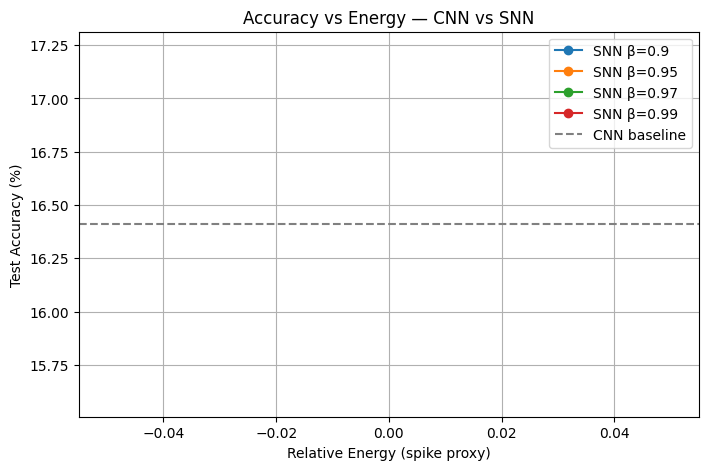

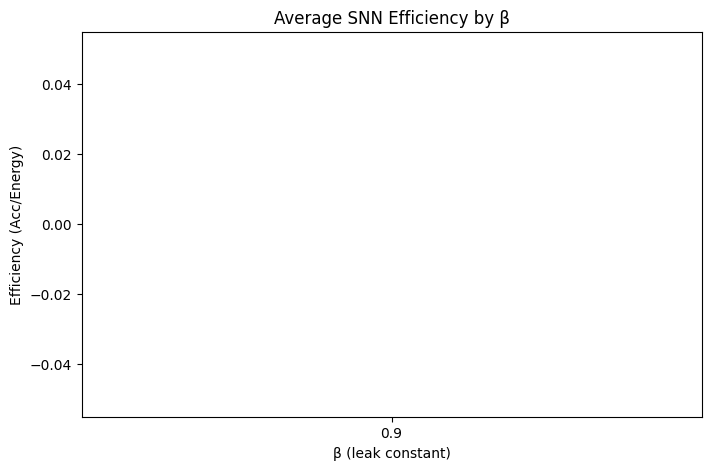

In [78]:
# Ensure numeric types
numeric_cols = ["beta", "T", "val_acc", "test_acc", "avg_spike_rate", "energy_proxy"]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Recompute energy + efficiency
cnn_energy_proxy = 1.0
df["relative_energy"] = df["energy_proxy"] / cnn_energy_proxy
df["efficiency"] = df["test_acc"] / df["relative_energy"]
display(df.head())

# Then plot
plt.figure(figsize=(8,5))
for beta in df[df["model"]=="SNN"]["beta"].unique():
    subset = df[(df["model"]=="SNN") & (df["beta"]==beta)]
    plt.plot(subset["relative_energy"], subset["test_acc"], 'o-', label=f"SNN β={beta}")
plt.axhline(y=df[df["model"]=="CNN"]["test_acc"].values[0], color='gray', linestyle='--', label="CNN baseline")
plt.xlabel("Relative Energy (spike proxy)")
plt.ylabel("Test Accuracy (%)")
plt.title("Accuracy vs Energy — CNN vs SNN")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
subset = df[df["model"]=="SNN"].groupby("beta")["efficiency"].mean().reset_index()
plt.bar(subset["beta"].astype(str), subset["efficiency"])
plt.ylabel("Efficiency (Acc/Energy)")
plt.xlabel("β (leak constant)")
plt.title("Average SNN Efficiency by β")
plt.show()

,beta,T,val_acc,test_acc,avg_spike_rate,energy_score,model,energy_proxy
0,0.9,10,17.628774,16.977310,0.000000,0.000000,NaN,NaN
1,0.9,25,17.628774,16.977310,0.000000,0.000000,NaN,NaN
2,0.9,50,17.628774,16.977310,0.000000,0.000000,NaN,NaN
3,0.9,75,17.628774,16.977310,0.000000,0.000000,NaN,NaN
4,0.9,100,17.628774,16.977310,0.000000,0.000000,NaN,NaN
5,0.95,10,17.628774,16.977310,0.000000,0.000000,NaN,NaN
6,0.95,25,17.628774,16.977310,0.000000,0.000000,NaN,NaN
7,0.95,50,17.628774,16.977310,0.000000,0.000000,NaN,NaN
8,0.95,75,17.628774,16.977310,0.000000,0.000000,NaN,NaN
9,0.95,100,17.628774,16.977310,0.000000,0.000000,NaN,NaN


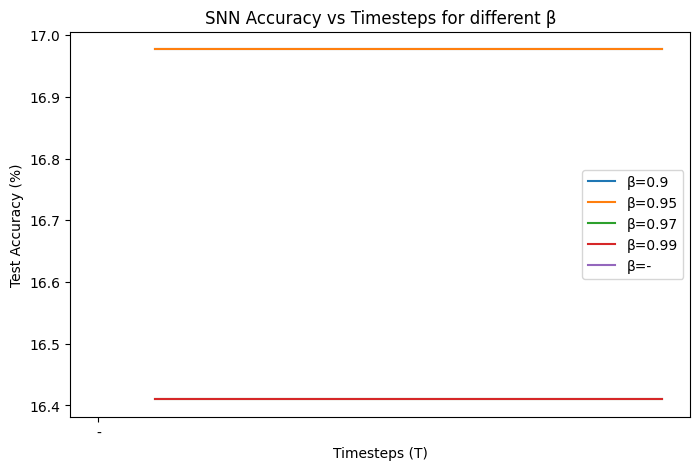

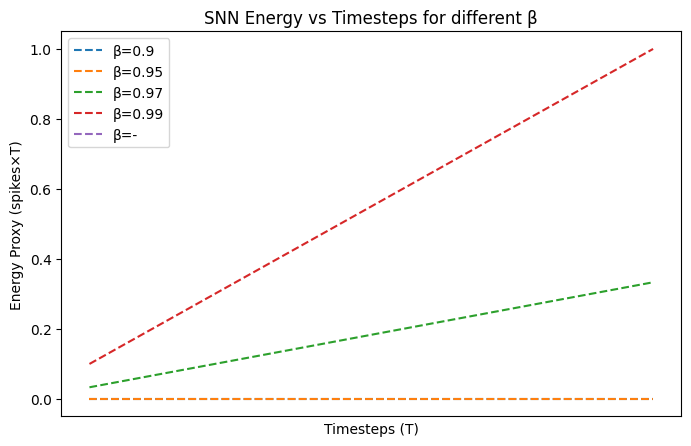

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(results)
display(df.sort_values(by=["beta", "T"]))

plt.figure(figsize=(8,5))
for beta in df["beta"].unique():
    subset = df[df["beta"]==beta]
    plt.plot(subset["T"], subset["test_acc"], label=f"β={beta}")
plt.xlabel("Timesteps (T)")
plt.ylabel("Test Accuracy (%)")
plt.title("SNN Accuracy vs Timesteps for different β")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
for beta in df["beta"].unique():
    subset = df[df["beta"]==beta]
    plt.plot(subset["T"], subset["energy_score"], '--', label=f"β={beta}")
plt.xlabel("Timesteps (T)")
plt.ylabel("Energy Proxy (spikes×T)")
plt.title("SNN Energy vs Timesteps for different β")
plt.legend()
plt.show()